# Imports

In [ ]:
# import 
%pip install python-mnist
from mnist import MNIST

mndata = MNIST('samples')

from google.colab import drive

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime 

from sklearn.metrics import confusion_matrix

y=np.array([[1, 2, 3], [4, 5, 6]])
z=torch.from_numpy(y)
y[1,2]=23

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available():
    device = torch.device("cuda")
    onGpu=z.to(device)
    print(onGpu)
else:
    print("no CUDA for you!")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
tensor([[ 1,  2,  3],
        [ 4,  5, 23]], device='cuda:0')


# Mount the Drive so you can access the data

In [ ]:
drive.mount('/content/drive', force_remount=True) 

%cd /content/drive/MyDrive/489/CSCE489/HW3
directory='./content/drive/MyDrive/489/CSCE489/HW3'

Mounted at /content/drive
/content/drive/MyDrive/489/CSCE489/HW3


# Load Dataset Files With Dataset Class

### Label Files
#### The label files have a 4 byte integer for the number of items, followed by 1 unsigned byte per label 

In [ ]:
# Read the first few bytes initially, and then use file.read to get the rest of the file
 
# read first label file
with open("hw3-letters-train-labels-idx1-ubyte", "rb") as label1_file:
    
    contents1 = label1_file.read(4)
    contents2 = label1_file.read()
    nmp1 = np.frombuffer(contents1, dtype=">i4", count = 1)
    label1_file.seek(4)
    train_label_data = np.frombuffer(contents2, dtype=">i1")
    train_label_data = [(x-1) for x in train_label_data]
    
    print("Labels Train:\n")
    print("Number of Items:", nmp1)
    print("1 unsigned byte per pixel from 0-25:\n", train_label_data[0:100])
    print("\n")
    
# read second label file
with open("hw3-letters-test-labels-idx1-ubyte", "rb") as label2_file:
    
    contents1 = label2_file.read(4)
    contents2 = label2_file.read()

    nmp1 = np.frombuffer(contents1, dtype=">i4", count = 1)
    label2_file.seek(4)
    test_label_data = np.frombuffer(contents2, dtype=">i1")
    test_label_data = [(x-1) for x in test_label_data]
    print("Labels Test:\n")
    print("Number of Items:", nmp1)
    print("1 unsigned byte per pixel from 0-25:\n", test_label_data[0:100])
    print("\n")

Labels Train:

Number of Items: [124800]
1 unsigned byte per pixel from 0-25:
 [22, 6, 15, 14, 22, 16, 12, 10, 21, 23, 9, 13, 17, 20, 25, 20, 20, 23, 18, 4, 1, 24, 8, 4, 9, 20, 10, 23, 11, 0, 16, 8, 0, 23, 17, 0, 7, 3, 0, 8, 6, 20, 2, 15, 1, 19, 9, 11, 10, 19, 2, 5, 12, 14, 10, 3, 22, 11, 20, 0, 15, 13, 22, 9, 4, 11, 5, 1, 1, 0, 1, 0, 1, 7, 20, 12, 23, 4, 6, 6, 21, 23, 4, 19, 18, 11, 4, 2, 7, 25, 10, 25, 7, 15, 9, 7, 25, 11, 24, 8]


Labels Test:

Number of Items: [20800]
1 unsigned byte per pixel from 0-25:
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]




### Image Files
#### The image files have a 4 byte integer for the number of images, followed by a 4 byte integer for number of row, followed by a 4 byte integer for number of columns, followed by 1 unsigned byte per pixel (0-255, white -> black) 

In [ ]:
# First Image File
with open("hw3-letters-train-images-idx3-ubyte", "rb") as image1_file:
    
    contents1 = image1_file.read(4)
    image1_file.seek(4)
    contents2 = image1_file.read(4)
    image1_file.seek(8)
    contents3 = image1_file.read(4)
    image1_file.seek(12)
    contents4 = image1_file.read() # after the first 12 bytes do a regular f.read

    nmp1 = np.frombuffer(contents1, dtype=">i4", count = 1)
    nmp2 = np.frombuffer(contents2, dtype=">i4", count = 1)
    nmp3 = np.frombuffer(contents3, dtype=">i4", count = 1)
    train_image_data = np.frombuffer(contents4, dtype=">i1")
    
    train_image_data = train_image_data.reshape(nmp1[0], nmp2[0], nmp3[0])
    
    print("Image Train:\n")
    print("Number of Images:", nmp1)
    print("Number of Rows:", nmp2)
    print("Number of Columns:",nmp3)
    print("1 unsigned byte per pixel from 0-255:\n",train_image_data[0:100])
    print("\n")
    
# Second Image file
with open("hw3-letters-test-images-idx3-ubyte", "rb") as image1_file:
    
    contents1 = image1_file.read(4)
    image1_file.seek(4)
    contents2 = image1_file.read(4)
    image1_file.seek(8)
    contents3 = image1_file.read(4)
    image1_file.seek(12)
    contents4 = image1_file.read() # after the first 12 bytes do a regular f.read

    nmp1 = np.frombuffer(contents1, dtype=">i4", count = 1)
    nmp2 = np.frombuffer(contents2, dtype=">i4", count = 1)
    nmp3 = np.frombuffer(contents3, dtype=">i4", count = 1)
    test_image_data = np.frombuffer(contents4, dtype=">i1")
    test_image_data = test_image_data.reshape(nmp1[0], nmp2[0], nmp3[0])
    
    print("Image Test:\n")
    print("Number of Images:", nmp1)
    print("Number of Rows:", nmp2)
    print("Number of Columns:",nmp3)
    print("1 unsigned byte per pixel from 0-255:\n",test_image_data[0:10])


# value should be from 0-255
# shape should be 28x28 & > 124,000
#plot images with the labels
#images should look like letters and labels should match up
# convert images to floating type

Image Train:

Number of Images: [124800]
Number of Rows: [28]
Number of Columns: [28]
1 unsigned byte per pixel from 0-255:
 [[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


Image Test:

Number of Images: [20800]
Number of Rows: [28]
Number of Columns: [28]
1 unsigned byte

# Create a child class for torch.utils.data.Dataset 

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, label_file, img_file):
      with open(label_file, "rb") as label1_file:
        contents1 = label1_file.read(4)
        contents2 = label1_file.read()
        
        nmp1 = np.frombuffer(contents1, dtype=">i4", count = 1)
        label1_file.seek(4)
        label_data = np.frombuffer(contents2, dtype=">i1")
        
        label_data = np.array([(x-1) for x in label_data])
        
        self.labels = label_data

      with open(img_file, "rb") as image1_file:
        contents1 = image1_file.read(4)
        image1_file.seek(4)
        contents2 = image1_file.read(4)
        image1_file.seek(8)
        contents3 = image1_file.read(4)
        image1_file.seek(12)
        contents4 = image1_file.read()

        nmp1 = np.frombuffer(contents1, dtype=">i4", count = 1)
        nmp2 = np.frombuffer(contents2, dtype=">i4", count = 1)
        nmp3 = np.frombuffer(contents3, dtype=">i4", count = 1)
        image_data = np.frombuffer(contents4, dtype=">i1")
        
        image_data = image_data.reshape(nmp1[0], nmp2[0], nmp3[0])
        
        self.images = image_data

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return (image, label)

### Helper Functions

In [ ]:
# parameters
RANDOM_SEED = 74
LEARNING_RATE = 0.0001
BATCH_SIZE = 1
N_EPOCHS = 15

IMG_SIZE = 28
N_CLASSES = 26

def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')
    
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

### Load into DataLoaders

In [ ]:
trains = CustomImageDataset(label_file="hw3-letters-train-labels-idx1-ubyte", img_file="hw3-letters-train-images-idx3-ubyte")
tests = CustomImageDataset(label_file="hw3-letters-test-labels-idx1-ubyte", img_file="hw3-letters-test-images-idx3-ubyte")

# Plot at least 20 of the images using matplotlib.pyplot.imshow

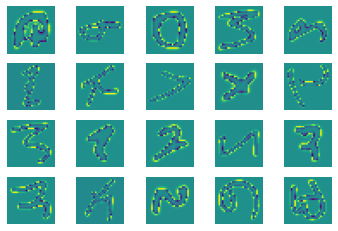

In [ ]:
ROW_IMG = 5
N_ROWS = 4
fig = plt.figure()
for i in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, i)
    plt.axis('off')
    plt.imshow(trains.images[i])

# Train a convolutional neural network to recognize the 26 letters

In [ ]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=4, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=4, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=4, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x.unsqueeze(1))
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [ ]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Labels are long integers, and images are floats
trains.labels = torch.tensor(trains.labels, dtype=torch.long)
tests.labels = torch.tensor(tests.labels, dtype=torch.long)
trains.images = torch.tensor(trains.images, dtype = torch.float)
tests.images = torch.tensor(tests.images,dtype = torch.float)
print(trains.labels.type())

torch.LongTensor


###Call DataLoader

In [ ]:
train_dataloader = DataLoader(trains, batch_size=1, shuffle=True)
test_dataloader = DataLoader(tests, batch_size=1, shuffle=False)

In [ ]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_dataloader, test_dataloader, N_EPOCHS, DEVICE)

KeyboardInterrupt: ignored

In [ ]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_dataloader, test_dataloader, N_EPOCHS, DEVICE)

# Compare the time to train the model with and without a hardware accelerator


In [ ]:
# Without Hardware Acceleterator: 1 hour, 18 minutes, 47 seconds
# With Hardware Accelerator: 2 hours, 4 minutes, and 21 seconds

# Output a confusion matrix of the test set with model

In [ ]:
# Confusion Matrix and Classification Report
# np.zeros([28, 28])
tn, fp, fn, tp = confusion_matrix(tests.images, model).ravel()  # flattening the array and list expansion
print("# of True Negatives: ", tn)
print("# of False Positives: ", fp)
print("# of False Negatives: ", fn)
print("# of True Positives: ", tp)